<a href="https://colab.research.google.com/github/arima1998/Arima/blob/master/ACO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Minimum distance is: 5.565759526523413 (Euclidean)


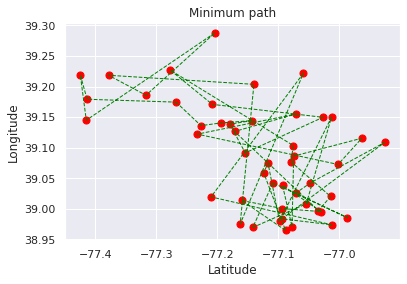

In [8]:
#! usr/bin/python3

import numpy as np
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")


def init_ants(space, colony):
    """Initialize ant positions by selecting random nodes of the sample space.

    Arguments:
        space {numpy.ndarray} -- The samples space
        colony {int} -- Number of ants in the colony

    Returns:
        numpy.ndarray -- An array of indices of position in the sample space
    """

    init_pos = np.random.randint(space.shape[0], size=colony)
    return init_pos


def find_inv_distance(space, beta):
    """Finds the inverse euclidean distances for all the nodes to all the nodes in the sample space.

    Arguments:
        space {numpy.ndarray} -- The sample space
        beta {int/float} -- ACO prameter beta

    Returns:
        numpy.ndarray -- A space.dimension x space.dimension array of inverse distances
    """

    # Empty holder for distances
    distances = np.zeros((space.shape[0], space.shape[0]))
    # Find distances for all nodes to all nodes
    for index, point in enumerate(space):
        distances[index] = np.sqrt(((space - point) ** 2).sum(axis=1))
    # Invert the distances
    with np.errstate(all='ignore'):
        inv_distance = 1 / distances
    # Replace infinity by zero(zero division error)
    inv_distance[inv_distance == np.inf] = 0
    return inv_distance ** beta


def ants_move(space, pos, inv_distance, pheromones, alpha, beta, del_tau):
    """Moves the ants from starting position to cover all the nodes.

    Arguments:
        space {numpy.ndarray} -- The sample space
        pos {numpy.ndarray} -- The starting position of the ants
        inv_distance {numpy.ndarray} -- The distances between nodes
        pheromones {numpy.ndarray} -- The amount of pheromones at each node.
        alpha {int/float} -- ACO parameter alpha
        beta {int/float} -- ACO parameter beta
        del_tau {int/float} -- ACO parameter delta tau

    Returns:
        numpy.ndarray -- The indices of the path taken by the ant
    """

    # Empty holder for the path indices
    paths = np.zeros((space.shape[0], pos.shape[0]), dtype=int) - 1
    # Initial position at node zero
    paths[0] = pos
    # For nodes after start till end
    for node in range(1, space.shape[0]):
        # For each ant
        for ant in range(pos.shape[0]):
            # Probability to travel to nodes
            next_loc_prob = (
                (inv_distance[pos[ant]] ** alpha) * (pheromones[pos[ant]] ** beta) /
                (inv_distance[pos[ant]].sum() ** alpha) *
                (pheromones[pos[ant]].sum() ** beta)
            )
            # Index to maximum probability node
            next_pos = np.argwhere(
                next_loc_prob == np.amax(next_loc_prob))[0][0]
            # Check if node has been already visited
            while next_pos in paths[:, ant]:
                # Replace the probability of visited by zero
                next_loc_prob[next_pos] = 0.0
                # Find the maximum probability
                next_pos = np.argwhere(
                    next_loc_prob == np.amax(next_loc_prob))[0][0]
            # Add node to path
            paths[node, ant] = next_pos
            # Update pheromones
            pheromones[node, next_pos] = pheromones[node, next_pos] + del_tau
    return np.swapaxes(paths, 0, 1)


def run_aco(space, iters=50, colony=25, alpha=1.0, beta=1.0, del_tau=0.5, rho=0.5):
    """Runs the main Ant Colony Optimization algorithm.

    Arguments:
        space {numpy.ndarray} -- The sample space

    Keyword Arguments:
        iters {int} -- Number of iterations (default: {30})
        colony {int} -- Number of ants in the colony (default: {50})
        alpha {int/float} -- ACO parameter alpha (default: {1.0})
        beta {int/float} -- ACO parameter beta (default: {1.0})
        del_tau {int/float} -- ACO parameter delta tau (default: {0.5})

    Returns:
        Tuple(numpy.ndarray, float) -- Indices of the minimum distance path and the minimum distance
    """

    # Find inverted distances for all the nodes in space
    inv_distance = find_inv_distance(space, beta)
    # Initialize pheromones randomly
    pheromones = np.random.rand(space.shape[0], space.shape[0])
    # Empty holder for minimum distance and path
    min_distance = None
    min_path = None
    # For the number of iterations
    for _ in range(iters):
        # GEnerate initial random positions
        init_pos = init_ants(space, colony)
        # Complete a path
        paths = ants_move(space, init_pos, inv_distance,
                          pheromones, alpha, beta, del_tau)
        # Evaporate the pheromones
        pheromones *= (1 - rho)
        # For each path
        for path in paths:
            # Empty holder for distance
            distance = 0
            # For each node from 2nd to last
            for node in range(1, path.shape[0]):
                # Calculate distance to the last node
                distance += np.sqrt(((space[int(path[node])] -
                                    space[int(path[node-1])]) ** 2).sum())
            # Update minimum distance and path if less nor non existent
            if not min_distance or distance < min_distance:
                min_distance = distance
                min_path = path
    # Copy and append first node to end of minimum path to form closed path
    min_path = np.append(min_path, min_path[0])
    return (min_path, min_distance)


def main():
    # Read CSV data file
    post_off_data = pandas.read_csv("post_offices.csv")
    # Create array of latitude and longitude
    space = np.array([post_off_data.values[:, 6],
                     post_off_data.values[:, 7]], dtype=np.float_)
    # Rearrange data
    space = np.swapaxes(space, 0, 1)
    # Run ACO and find minimum distance and path
    min_path, min_distance = run_aco(space, 100, 25, 1, 0.5, 1, 0.5)
    # Print minimum distance
    print("Minimum distance is: {} (Euclidean)".format(min_distance))
    # Place the data nodes
    plt.scatter(space[:, 0], space[:, 1], c='r', marker='o', s=50.0)
    # Plot the minimum path
    plt.plot(space[min_path, 0], space[min_path, 1],
             c='g', linewidth=1.0, linestyle='--')
    # Set plot properties
    plt.title("Minimum path")
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    # Show plot
    plt.show()


if __name__ == '__main__':
    main()

In [9]:
%matplotlib inline
#from aco import run_aco
import numpy as np
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")

In [10]:
# Read CSV data file
post_off_data = pandas.read_csv("post_offices.csv")
# Create array of latitude and longitude
space = np.array([post_off_data.values[:, 6], post_off_data.values[:, 7]], dtype=np.float_)
# Rearrange data
space = np.swapaxes(space, 0, 1)

In [11]:
# Adjust hyper-parameters
iterations=100
colony_size=25
alpha=1
beta=0.5
del_tau=1
rho=0.5
# Run the algorithm
min_path, min_distance = run_aco(space, iterations, colony_size, alpha, beta, del_tau, rho)

Minimum distance is: 5.577226445039987 (Euclidean)


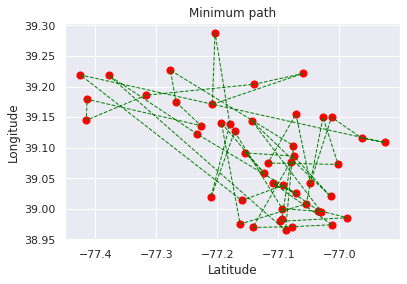

In [12]:
# Print minimum distance
print("Minimum distance is: {} (Euclidean)".format(min_distance))
# Place the data nodes

plt.scatter(space[:, 0], space[:, 1], c='r', marker='o', s=50.0)
# Plot the minimum path
plt.plot(space[min_path, 0], space[min_path, 1], c='g', linewidth=1.0, linestyle='--')
# Set plot properties
plt.title("Minimum path")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
# Show plot
plt.show()